## SEIS 764-01 Assignment 9
**Jamie Boehme**

Import libraries for processing

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import utils
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

Read data from google colab drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/Colab Notebooks/CNN_Flowers"

Mounted at /content/drive


In [3]:
batch_size = 10

data = ImageDataGenerator(rescale=1. / 255, 
                          validation_split=0.2)

training_data = data.flow_from_directory('/content/drive/My Drive/Colab Notebooks/Iris_Imgs', 
                                         target_size=(224, 224), shuffle=True, batch_size = batch_size, 
                                         class_mode='categorical', subset='training')

training_data_noshuffle = data.flow_from_directory('/content/drive/My Drive/Colab Notebooks/Iris_Imgs', 
                                         target_size=(224, 224), shuffle=False, batch_size = batch_size, 
                                         class_mode='categorical', subset='training')

test_data = data.flow_from_directory('/content/drive/My Drive/Colab Notebooks/Iris_Imgs', 
                                     target_size=(224, 224), batch_size = batch_size, shuffle=False,
                                     class_mode='categorical', subset='validation')

Found 120 images belonging to 3 classes.
Found 120 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


Train initial pre-built model

In [4]:
cnn_xfer = tf.keras.applications.VGG16(
    include_top = False,
    weights = "imagenet",
    input_shape = (224,224,3)
)

cnn_xfer.trainable=False #freezing weights

58889256/58889256 [==============================] - 0s 0us/step


3. Print the configurations of all the layers in the CNN

In [5]:
cnn_xfer.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

2. Write a program using Python Keras, MatLab, or any programming language of 
your choice to classify images into 3 classes (setosa, versicolor, virginica) using any pre-trained CNN listed on slide 7 to 9 

In [6]:
flatten_layer = tf.keras.layers.Flatten()
dense_layer_1 = Dense(500, activation='relu')
dense_layer_2 = Dense(250, activation='relu')
dense_layer_3 = Dense(50, activation='relu')
prediction_layer = Dense(3, activation='softmax')


model = Sequential([
    cnn_xfer,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    dense_layer_3,
    prediction_layer
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 500)               12544500  
                                                                 
 dense_1 (Dense)             (None, 250)               125250    
                                                                 
 dense_2 (Dense)             (None, 50)                12550     
                                                                 
 dense_3 (Dense)             (None, 3)                 153       
                                                                 
Total params: 27,397,141
Trainable params: 12,682,453
No

In [8]:
#opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
model.fit(training_data, batch_size = 10, epochs = 30, validation_data=test_data, shuffle = 1, verbose = 1)

4. Print the confusion matrix of your classification result, and what is the accuracy of classification result? Below are the results of the **test** data

In [10]:
training_data.reset()
test_data.reset()

predicted_scores = model.predict(test_data, verbose=1)
predicted_labels = predicted_scores.argmax(axis=1) 

test_labels = test_data.labels

acc_score_xfer_cnn = accuracy_score(test_labels, predicted_labels)
xfer_cnn_cfm = confusion_matrix(test_labels, predicted_labels)

print("Accuracy score: ", acc_score_xfer_cnn)
print("Confusion Matrix: \n", xfer_cnn_cfm)

3/3 [==============================] - 16s 5s/step
Accuracy score:  0.9333333333333333
Confusion Matrix: 
 [[ 8  2  0]
 [ 0 10  0]
 [ 0  0 10]]


5. Print the precision, recall, F-score for EACH class. Also, create a ROC curve and measure its AUC for EACH class.

In [11]:
print("Classification Matrix: \n", classification_report(test_labels, predicted_labels))

Classification Matrix: 
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.83      1.00      0.91        10
           2       1.00      1.00      1.00        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



1.0
0.99
1.0


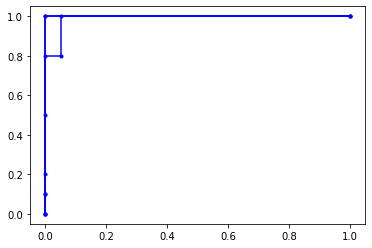

In [12]:
y_pred_keras = predicted_scores
from sklearn.preprocessing import label_binarize
y_test = label_binarize(test_data.labels, classes=[0,1,2])
n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()

for cur_class in range(n_classes):
    fpr[cur_class], tpr[cur_class], _ = roc_curve(y_test[:, cur_class], y_pred_keras[:, cur_class ])  #, pos_label= 1)
    roc_auc[cur_class] = auc(fpr[cur_class], tpr[cur_class])
    print(roc_auc[cur_class])
    plt.plot(fpr[cur_class],tpr[cur_class], marker='.', label='Class_0', color='b')